Sample the dataset, train the model on it, report the accuracy; then add more data to see if it improves the accuracy. This is useful for determining whether adding the data will help with the task at hand.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# 60,000 train examples, 10,000 test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#%% Display some images with a gray color map
for i in range(5):
    plt.imshow(X_test[i], cmap='gray') 
    plt.show()


Using TensorFlow backend.


In [2]:
X_train.shape

(60000, 28, 28)

In [ ]:
#%% Vectorize inputs
# Recall that tuples are defined as (a, b, ...,)
# Double parenthesis below is to create an explicit tuple
# np.reshape() converts 28x28 examples in 784-dimensional samples (28*28)
# The -1 argument means infer the dimension of this argument, in this case 60,000
Xv_train = X_train.reshape((-1, 784))
Xv_test = X_test.reshape((-1, 784))

In [8]:
!ls images

bmw.png            clint_eastwood.jpg office.png         soccer_ball.jpg
boat.png           jemma.png          scotch.png         tv.png


In [1]:
import os
import numpy as np
from glob import glob
from skimage.io import imread
from IPython.display import Image
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


(374, 500, 3)


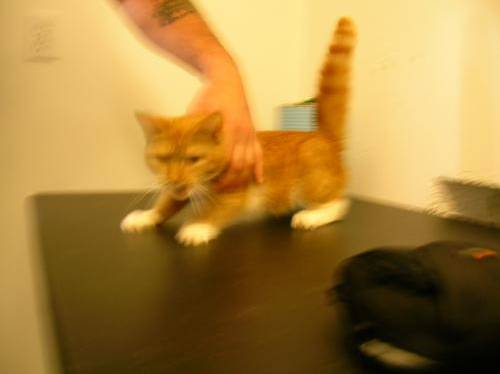

In [11]:
sample_img = os.path.join('train', 'cat.0.jpg')
img = imread(sample_img)
print(img.shape)
Image(filename = sample_img) 

(374, 500, 3)

In [10]:
img = load_img(sample_img, target_size=(224, 224))
img.show()

In [23]:
glob(os.path.join('train', '*.jpg'))

['train/cat.0.jpg',
 'train/cat.1.jpg',
 'train/cat.10.jpg',
 'train/cat.100.jpg',
 'train/cat.1000.jpg',
 'train/cat.10000.jpg',
 'train/cat.10001.jpg',
 'train/cat.10002.jpg',
 'train/cat.10003.jpg',
 'train/cat.10004.jpg',
 'train/cat.10005.jpg',
 'train/cat.10006.jpg',
 'train/cat.10007.jpg',
 'train/cat.10008.jpg',
 'train/cat.10009.jpg',
 'train/cat.1001.jpg',
 'train/cat.10010.jpg',
 'train/cat.10011.jpg',
 'train/cat.10012.jpg',
 'train/cat.10013.jpg',
 'train/cat.10014.jpg',
 'train/cat.10015.jpg',
 'train/cat.10016.jpg',
 'train/cat.10017.jpg',
 'train/cat.10018.jpg',
 'train/cat.10019.jpg',
 'train/cat.1002.jpg',
 'train/cat.10020.jpg',
 'train/cat.10021.jpg',
 'train/cat.10022.jpg',
 'train/cat.10023.jpg',
 'train/cat.10024.jpg',
 'train/cat.10025.jpg',
 'train/cat.10026.jpg',
 'train/cat.10027.jpg',
 'train/cat.10028.jpg',
 'train/cat.10029.jpg',
 'train/cat.1003.jpg',
 'train/cat.10030.jpg',
 'train/cat.10031.jpg',
 'train/cat.10032.jpg',
 'train/cat.10033.jpg',
 'train/c

In [1]:
import os
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception # TensorFlow ONLY
from keras.applications import VGG16
from keras.applications import VGG19
#from keras.applications import imagenet_utils
#from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

Using TensorFlow backend.


In [28]:
import os
import numpy as np
from keras.models import Model
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.preprocessing.image import load_img, img_to_array

base_model = VGG19(weights = 'imagenet')
model = Model(inputs = base_model.inputs, outputs = base_model.get_layer('fc2').output)

img_dir = 'images'
img_path = os.path.join(img_dir, 'bmw.png')
img = load_img(img_path, target_size = (224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
preds = model.predict(x)

In [13]:
preds = decode_predictions(preds)
for i, (imagenetID, label, prob) in enumerate(preds[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

1. convertible: 94.33%
2. sports_car: 3.97%
3. car_wheel: 0.46%
4. limousine: 0.41%
5. beach_wagon: 0.19%


## Reference

- [Keras Documentation: Keras Application](https://keras.io/applications/)
- [Blog: Neural Network Architectures](https://culurciello.github.io/tech/2016/06/04/nets.html)
- [Blog: One by One [1 x 1] Convolution - counter-intuitively useful](http://iamaaditya.github.io/2016/03/one-by-one-convolution/)
- [Blog: ImageNet: VGGNet, ResNet, Inception, and Xception with Keras](http://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)
- [StackExchange: What does 1x1 convolution mean in a neural network?](http://stats.stackexchange.com/questions/194142/what-does-1x1-convolution-mean-in-a-neural-network)